In [1]:
import os
from os import getcwd
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [3]:
train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [4]:
test.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
56474,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 05:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56477,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.098612
56480,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 07:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56483,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2021-08-10 09:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
56486,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 10:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147


In [5]:
def _encode_dates(X):
    X = X.copy()
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    return X.drop(columns=["date"])

In [6]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [7]:
_encode_dates(X_train[["date"]].head())

,year,month,day,weekday,hour
400125,2020,9,1,1,1
408305,2020,9,1,1,1
87516,2020,9,1,1,1
98518,2020,9,1,1,1
875137,2020,9,1,1,1


## 1. MERGE EXTERNAL DATA

In [8]:
df_weather = pd.read_csv("submissions/starting_kit/external_data.csv", parse_dates=["date"])

In [9]:
X_train["orig_index"] = np.arange(X_train.shape[0])
X_train_merged = pd.merge_asof(X_train.sort_values("date"), df_weather.sort_values("date"), on='date')
X_train_merged = X_train_merged.sort_values("orig_index")
del X_train_merged["orig_index"]

#### A. Feature selection

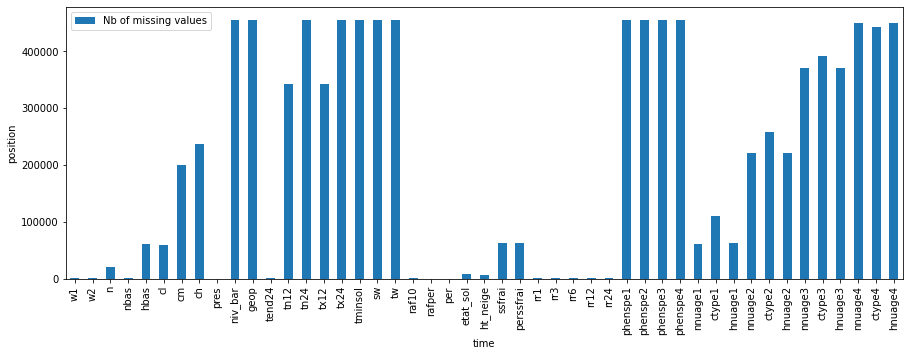

In [28]:
import matplotlib.pyplot as plt
X_train_merged[['w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm',
       'ch', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12',
       'tx24', 'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol',
       'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24',
       'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1',
       'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3',
       'hnuage3', 'nnuage4', 'ctype4', 'hnuage4']].isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90, fontsize=10, figsize=(15 ,5));
plt.xlabel('time', fontsize=10)
plt.ylabel('position', fontsize=10)
L=plt.legend()
L.get_texts()[0].set_text('Nb of missing values')
plt.show
plt.savefig("missingvaluesmeteo.jpg")

In [11]:
X_train_merged.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'counter_technical_id', 'latitude',
       'longitude', 'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't',
       'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm',
       'ch', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12',
       'tx24', 'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol',
       'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24',
       'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1',
       'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3',
       'hnuage3', 'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')

In [12]:
X_train_merged.drop(['tn12', 'tn24', 'tx12','tx24', 'tminsol', 'sw', 'tw', 
                     'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1',
                     'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3',
                     'hnuage3', 'nnuage4', 'ctype4', 'hnuage4', 'niv_bar', 'geop', 'hbas', 'cl',
                     'cm', 'ch', 'numer_sta', 'per', 'longitude', 'latitude', 'counter_id', 'site_id', 
                     'site_name', 'counter_installation_date', 'coordinates'], axis=1, inplace=True)

KeyError: "['coordinates'] not found in axis"

In [ ]:
X_train_merged.columns

In [ ]:
import seaborn as sns
corr = X_train_merged.corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap = 'Blues');

In [ ]:
X_train_merged.columns

#### B. Merge function

In [16]:
def merge_external_data(X): 
    X_weather = df_weather[['date','tend', 'dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'etat_sol','rr3']]
    X["orig_index"] = np.arange(X.shape[0])
    X_merged = pd.merge_asof(X.sort_values("date"), X_weather.sort_values("date"), on='date')
    X_merged = X_merged.sort_values("orig_index")  
    del X_merged["orig_index"]
    X_merged.drop(['longitude', 'latitude', 'site_name', 'site_id', 'counter_id', 
                   'counter_installation_date', 'coordinates', 'counter_technical_id'], axis=1, inplace=True)
    return X_merged

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as ltb



date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_merged[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['tend', 'dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'etat_sol','rr3']

preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)

regressor = ltb.LGBMRegressor()


pipe = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [18]:
merger = pipe[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

In [19]:
predictor = pipe[2:]
_ = predictor.fit(X_train_augmented, y_train)

In [20]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)

In [ ]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
X_train_merged.columns

In [ ]:
X_train_merged.drop(['counter_technical_id', 'pmer', 'tend', 'cod_tend', 'dd', 'ff','raf10', 
                     'rafper', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr6', 
                     'rr12', 'rr24', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'pres', 
                     'tend24', 'td'], axis=1, inplace=True)

In [ ]:
X_train_merged.head()

In [ ]:
def merge_external_data(X): 
    X_weather = df_weather[['date','t', 'u']]
    X["orig_index"] = np.arange(X.shape[0])
    X_merged = pd.merge_asof(X.sort_values("date"), X_weather.sort_values("date"), on='date')
    X_merged = X_merged.sort_values("orig_index")  
    del X_merged["orig_index"]
    X_merged.drop(['longitude', 'latitude', 'site_name', 'site_id', 'counter_id', 
                   'counter_installation_date', 'coordinates', 'counter_technical_id'], axis=1, inplace=True)
    return X_merged

## LINEARITY

In [ ]:
y_train_bis = pd.DataFrame(y_train)

In [ ]:
y_train_bis.head

In [ ]:
datatest = X_train_merged
datatest['log_bike_count'] = y_train_bis

In [ ]:
datatest.columns

In [ ]:
datatest = _encode_dates(datatest)

predictor = pipe[2:]
_ = predictor.fit(X_train_augmented, y_train)

In [ ]:
sns.pairplot(data=datatest)

In [ ]:
datatest.columns

In [ ]:
import pandas_profiling
datatest.profile_report()

## 2. HIST GRADIENT BOOST

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"u"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = HistGradientBoostingRegressor(random_state=0)

pipe = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")
print(f"the model was trained in {elapsed_time:.3f}")

## 3. RIDGE / LASSO

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"u"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = Lasso()

pipe2 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe2.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe2,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")
print(f"the model was trained in {elapsed_time:.3f}")

## 3. Elasticnet

In [ ]:
from sklearn.linear_model import ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"u"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = ElasticNet()

pipe3 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe3.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe3,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")
print(f"the model was trained in {elapsed_time:.3f}")

## 4.XGB

In [ ]:
import xgboost as xgb

from sklearn.linear_model import ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"u"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = xgb.XGBRegressor()

pipe4 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe4.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe4,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")
print(f"the model was trained in {elapsed_time:.3f}")

## 5. RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.linear_model import ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"u"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = RandomForestRegressor()

pipe5 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe5.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe5,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")
print(f"the model was trained in {elapsed_time:.3f}")

## 5. LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.linear_model import ElasticNet

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = lgb.LGBMRegressor()

pipe6 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe6.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe6,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")
print(f"the model was trained in {elapsed_time:.3f}")

## CATBOOST

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_cols = ["counter_name"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['t',"u"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = CatBoostRegressor()

pipe7 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score
import time

start = time.time()
pipe7.fit(X_train, y_train)
elapsed_time = time.time() - start 

scores = cross_val_score(
    pipe7,
    X_train_merged,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

In [ ]:
from sklearn.model_selection import GridSearchCV

pipe7.fit(X_train, y_train)
params = [{'depth' : [6,8,10],
           'learning_rate' : [0.01, 0.05, 0.1],
           'iterations'    : [30, 50, 100]}]
search = GridSearchCV(pipe7, params, cv = 5, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)
print(search.best_params_)